# **AAI-590 Capstone**
# Sarcasm & Non-Literal Speech Detection

### **Team 1:** Lisa Vo, Fernando Calderon, Zack Robertson




---



Dataset: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection <br>

## Project setup

In [ ]:
!pip install shap

In [ ]:
import nltk
import string
import re
import shap
import openai

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Embedding, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer, LancasterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Import data

In [ ]:
# !pip install -q kaggle

# from google.colab import files
# files.upload()

In [ ]:
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets list

In [ ]:
#!/bin/bash
!kaggle datasets download "rmisra/news-headlines-dataset-for-sarcasm-detection"

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection
License(s): Attribution 4.0 International (CC BY 4.0)
news-headlines-dataset-for-sarcasm-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip data
!mkdir "/content/news-headlines-dataset"
!unzip "/content/news-headlines-dataset-for-sarcasm-detection.zip" -d "/content/news-headlines-dataset"

mkdir: cannot create directory ‘/content/news-headlines-dataset’: File exists
Archive:  /content/news-headlines-dataset-for-sarcasm-detection.zip
replace /content/news-headlines-dataset/Sarcasm_Headlines_Dataset.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/news-headlines-dataset/Sarcasm_Headlines_Dataset_v2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# Read JSON file into DataFrame
df = pd.read_json("/content/news-headlines-dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# **Data Cleaning**

In [ ]:
# Drop the article link
df = df.drop(['article_link'], axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [ ]:
# Checking for duplicates
print(f"Number of duplicate headlines: {df.duplicated(subset='headline').sum()}")

# Drop duplicate headlines
df = df.drop_duplicates(subset='headline').reset_index(drop=True)
df.head()

Number of duplicate headlines: 116


,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [ ]:
# Check for duplicate count again
print(f"Number of duplicate headlines: {df.duplicated(subset='headline').sum()}")

Number of duplicate headlines: 0


In [ ]:
# Initialize functions for cleaning
stop_words = set(stopwords.words('english'))

def clean_tokenize(text):
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return words

def clean_text_no_stop_words(text):
    # Remove HTML tags if any
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove non-alphabetic characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    # Remove extra whitespaces
    text = re.sub('\s+', ' ', text).strip()
    return text

def clean_text_keep_stop_words(text):
    # Remove HTML tags if any
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove non-alphabetic characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub('\s+', ' ', text).strip()
    return text

In [ ]:
df['clean_headline'] = df['headline'].apply(clean_text_keep_stop_words)
df.head()

,is_sarcastic,headline,clean_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails why congress is falling ...
2,0,eat your veggies: 9 deliciously different recipes,eat your veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word stream...


In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['clean_headline'] = df['clean_headline'].apply(lemmatize_text)

In [ ]:
df.head()

,is_sarcastic,headline,clean_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nail why congress is falling s...
2,0,eat your veggies: 9 deliciously different recipes,eat your veggie deliciously different recipe
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,mother come pretty close to using word streami...


# **Exploratory Data Analysis**

In [ ]:
# Create dataframe for EDA
df_eda = df
df_eda['clean_headline'] = df['headline'].apply(clean_text_no_stop_words)

In [ ]:
# Check data types
df_eda.dtypes

,0
is_sarcastic,int64
headline,object
clean_headline,object


In [ ]:
# Check for NaN values
df_eda.isnull().sum()

,0
is_sarcastic,0
headline,0
clean_headline,0


In [ ]:
# Check for class imbalance
df_eda["is_sarcastic"].value_counts()

,count
is_sarcastic,
0,14951
1,13552


# Univariate analysis

## Word count

In [ ]:
# Check word count
word_count = df_eda['clean_headline'][0].split()
# Check word count of each headline and store in a new column
df_eda['word_count'] = df_eda['clean_headline'].map(lambda rev: len(rev.split()))

print(f'Word count in a sample headline: {len(word_count)}')

Word count in a sample headline: 7


## Sentiment analysis - Polarity



**Polarity** score ranges from **-1 to 1**. A lower score indicates a more negative sentiment. A higher score indicates a more positive sentiment.

In [ ]:
from textblob import TextBlob

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the 'clean_headline' column and create a new 'polarity' column
df_eda['polarity'] = df['clean_headline'].apply(get_polarity)
df_eda.head()

,is_sarcastic,headline,clean_headline,word_count,polarity
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...,7,0.00
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails congress falling short g...,10,0.00
2,0,eat your veggies: 9 deliciously different recipes,eat veggies deliciously different recipes,5,0.00
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar getting work,6,0.00
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close using word streaming...,8,0.25


## Sentiment analysis - Subjectivity

**Subjectivity** score goes from **0 to 1**. If it’s close to 1, it means the sentence has a lot of personal opinion instead of just facts.

In [ ]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Apply the function to the 'clean_headline' column and create a new 'subjectivity' column
df_eda['subjectivity'] = df_eda['clean_headline'].apply(get_subjectivity)

In [ ]:
df_eda.head()

,is_sarcastic,headline,clean_headline,word_count,polarity,subjectivity
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...,7,0.00,0.000
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails congress falling short g...,10,0.00,0.525
2,0,eat your veggies: 9 deliciously different recipes,eat veggies deliciously different recipes,5,0.00,0.600
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar getting work,6,0.00,0.000
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close using word streaming...,8,0.25,1.000


## Most Frequently Occurring Bigrams

### Get sarcastic dataframe and non-sarcastic dataframe

In [ ]:
# Get all rows where is_sarcastic is 1
df_sarcastic = df_eda[df_eda['is_sarcastic'] == 1]

# Get all rows where is_sarcastic is 0
df_not_sarcastic = df_eda[df_eda['is_sarcastic'] == 0]

In [ ]:
df_sarcastic.head()

,is_sarcastic,headline,clean_headline,word_count,polarity,subjectivity
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...,7,0.000000,0.000000
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar getting work,6,0.000000,0.000000
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close using word streaming...,8,0.250000,1.000000
7,1,richard branson's global-warming donation near...,richard branson global warming donation nearly...,11,-0.100000,0.166667
8,1,shadow government getting too large to meet in...,shadow government getting large meet marriott ...,9,0.214286,0.428571


In [ ]:
df_not_sarcastic.head()

,is_sarcastic,headline,clean_headline,word_count,polarity,subjectivity
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails congress falling short g...,10,0.000000,0.525000
2,0,eat your veggies: 9 deliciously different recipes,eat veggies deliciously different recipes,5,0.000000,0.600000
5,0,my white inheritance,white inheritance,2,0.000000,0.000000
6,0,5 ways to file your taxes with less stress,ways file taxes less stress,5,-0.166667,0.066667
9,0,lots of parents know this scenario,lots parents know scenario,4,0.000000,0.000000


### Top 10 Bigrams (Sarcastic)

In [ ]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df_sarcastic['clean_headline'])

In [ ]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

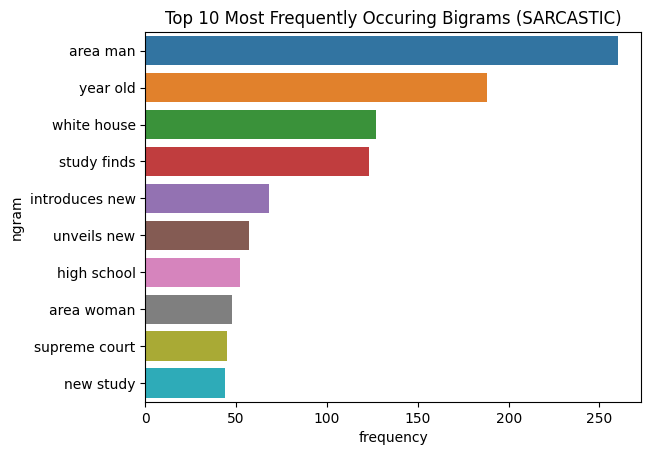

In [ ]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams (SARCASTIC)')
plt.show()

### Top 10 Bigrams (Not Sarcastic)

In [ ]:
bigrams = cv.fit_transform(df_not_sarcastic['clean_headline'])

In [ ]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

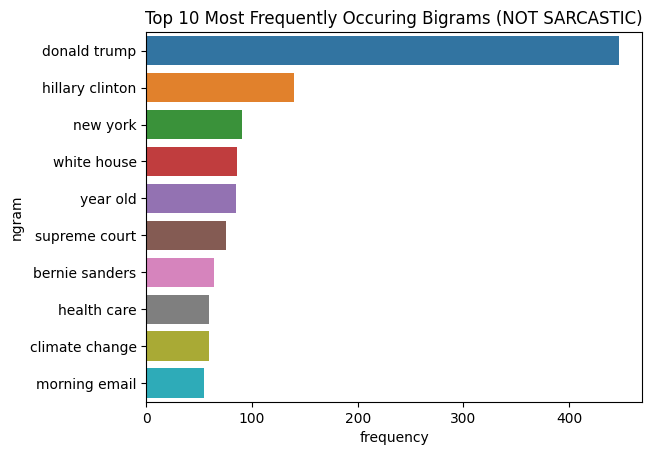

In [ ]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams (NOT SARCASTIC)')
plt.show()

### Top 10 Trigrams (Sarcastic)

In [ ]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df_sarcastic['clean_headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

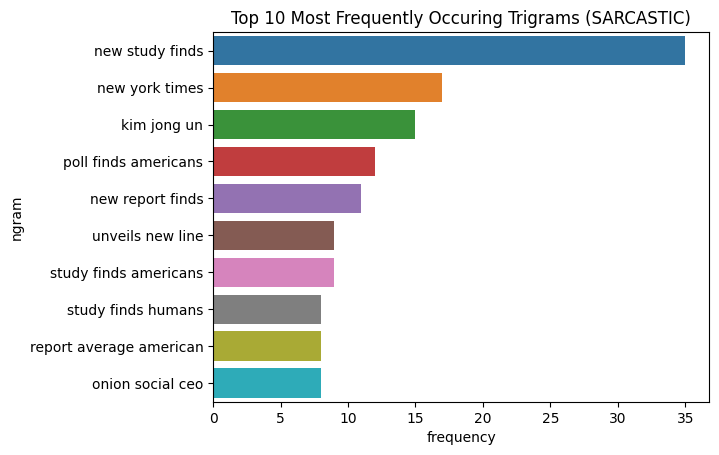

In [ ]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams (SARCASTIC)')
plt.show()

### Top 10 Trigrams (Not Sarcastic)

In [ ]:
trigrams = cv1.fit_transform(df_not_sarcastic['clean_headline'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

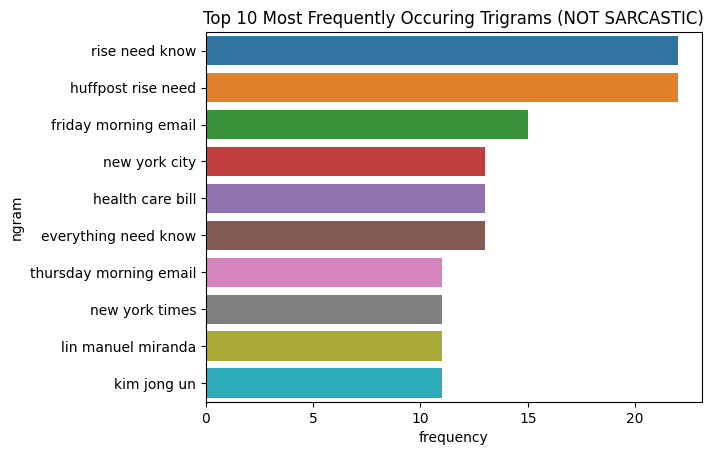

In [ ]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10], hue=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams (NOT SARCASTIC)')
plt.show()

# Bivariate analysis

### Word Count vs. Sarcasm

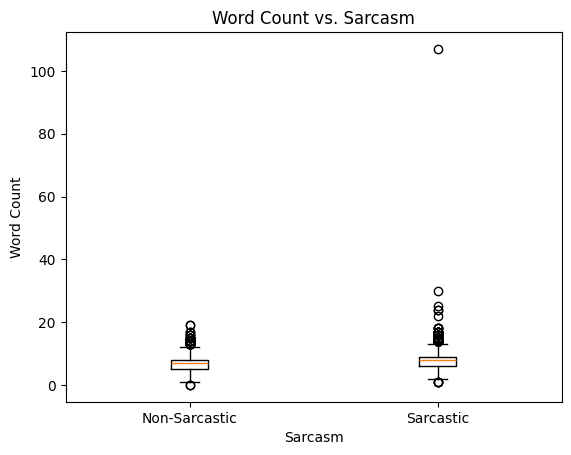

In [ ]:
# Create box plot
plt.boxplot([df_eda[df_eda['is_sarcastic'] == 0]['word_count'],
             df_eda[df_eda['is_sarcastic'] == 1]['word_count']],
            labels=['Non-Sarcastic', 'Sarcastic'])

# Add labels and title
plt.xlabel('Sarcasm')
plt.ylabel('Word Count')
_ = plt.title('Word Count vs. Sarcasm')

In [ ]:
# Delete rows where the word count is higher than 60
df_eda = df_eda[df_eda['word_count'] <= 60]

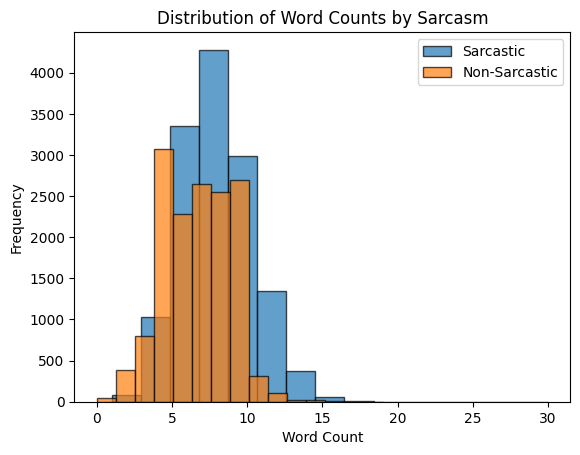

In [ ]:
# Filter data for sarcastic and non-sarcastic headlines
sarcastic_headlines = df_eda[df_eda['is_sarcastic'] == 1]['word_count']
non_sarcastic_headlines = df_eda[df_eda['is_sarcastic'] == 0]['word_count']

# Create histograms
plt.hist(sarcastic_headlines, bins=15, alpha=0.7, label='Sarcastic', edgecolor='black')
plt.hist(non_sarcastic_headlines, bins=15, alpha=0.7, label='Non-Sarcastic', edgecolor='black')

# Add labels and title
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts by Sarcasm')

# Add legend
_ = plt.legend()

### Polarity vs. Sarcasm

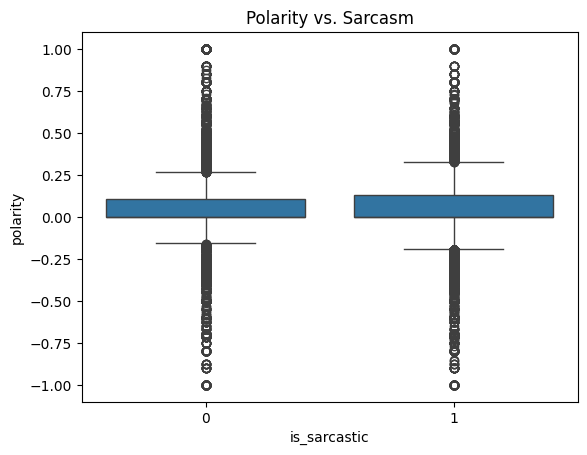

In [ ]:
# Perform bivariate analysis on polarity score and sarcasm
sns.boxplot(x='is_sarcastic', y='polarity', data=df_eda)
plt.title('Polarity vs. Sarcasm')
plt.show()

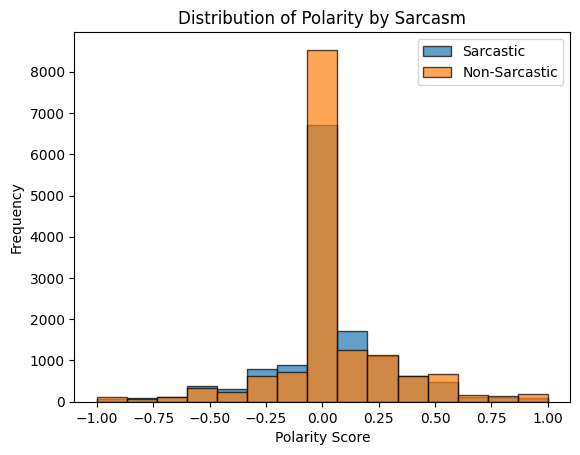

In [ ]:
# Filter data for sarcastic and non-sarcastic headlines
sarcastic_headlines = df_eda[df_eda['is_sarcastic'] == 1]['polarity']
non_sarcastic_headlines = df_eda[df_eda['is_sarcastic'] == 0]['polarity']

# Create histograms
plt.hist(sarcastic_headlines, bins=15, alpha=0.7, label='Sarcastic', edgecolor='black')
plt.hist(non_sarcastic_headlines, bins=15, alpha=0.7, label='Non-Sarcastic', edgecolor='black')

# Add labels and title
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Polarity by Sarcasm')

# Add legend
_ = plt.legend()

### Subjectivity vs. Sarcasm

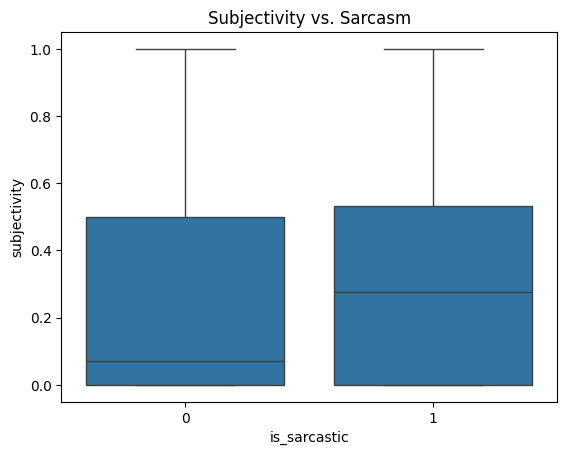

In [ ]:
# Perform bivariate analysis on polarity score and sarcasm
sns.boxplot(x='is_sarcastic', y='subjectivity', data=df_eda)
plt.title('Subjectivity vs. Sarcasm')
plt.show()

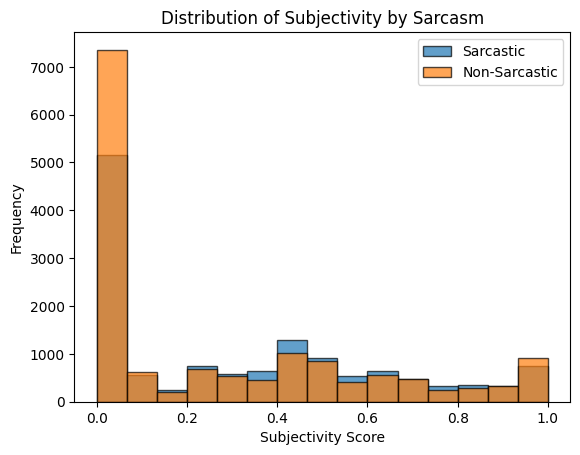

In [ ]:
# Filter data for sarcastic and non-sarcastic headlines
sarcastic_headlines = df_eda[df_eda['is_sarcastic'] == 1]['subjectivity']
non_sarcastic_headlines = df_eda[df_eda['is_sarcastic'] == 0]['subjectivity']

# Create histograms
plt.hist(sarcastic_headlines, bins=15, alpha=0.7, label='Sarcastic', edgecolor='black')
plt.hist(non_sarcastic_headlines, bins=15, alpha=0.7, label='Non-Sarcastic', edgecolor='black')

# Add labels and title
plt.xlabel('Subjectivity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Subjectivity by Sarcasm')

# Add legend
_ = plt.legend()

# Feature Engineering

At this point, we explored many new features generated during EDA. Based on our exploration, we can choose to include or exclude certain features for training. For the purposes of learning, we can include all of the new features, and then later explore the contribution of each feature to the overall performance using SHAP or LIME.

In [ ]:
# Display existing and new features
df_eda.dtypes

,0
is_sarcastic,int64
headline,object
clean_headline,object
word_count,int64
polarity,float64
subjectivity,float64


In [ ]:
# Rewrite the existing DataFrame with the EDA dataframe (the one with all the new features)
df = df_eda.copy()
df['clean_headline'] = df['headline'].apply(clean_text_keep_stop_words)
df.head()

,is_sarcastic,headline,clean_headline,word_count,polarity,subjectivity
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...,7,0.00,0.000
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails why congress is falling ...,10,0.00,0.525
2,0,eat your veggies: 9 deliciously different recipes,eat your veggies deliciously different recipes,5,0.00,0.600
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar from getting t...,6,0.00,0.000
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close to using word stream...,8,0.25,1.000


# Feature Extraction

In [ ]:
# Divide each numerical value by 1e6
df['word_count'] = df['word_count'] / 1e6
df['polarity'] = df['polarity'] / 1e6
df['subjectivity'] = df['subjectivity'] / 1e6

In [ ]:
# Split Data into Features and Labels
X = df.drop(['is_sarcastic','headline'], axis=1)
y = df['is_sarcastic']

# Save Cleaned Data
df.to_csv('/content/drive/MyDrive/Colab Notebooks/aai590-capstone/cleaned_sarcasm_dataset.csv', index=False)

## Split data

In [ ]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Save a copy of the raw train and test set
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

In [ ]:
X_train.head()

,clean_headline,word_count,polarity,subjectivity
27077,man s obituary accompanied by photo of him dre...,0.000006,0.000000e+00,0.000000e+00
20899,journalists who refuse to take the same non an...,0.000006,0.000000e+00,0.000000e+00
5673,report shit last night was trash night,0.000006,-1.000000e-07,4.333333e-07
5262,the importance of first responders,0.000003,2.500000e-07,3.333333e-07
3059,man who should be president has asymmetrical e...,0.000004,0.000000e+00,0.000000e+00


In [ ]:
y_train.head()

,is_sarcastic
27077,1
20899,0
5673,1
5262,0
3059,1


## Normalize numerical features

In [ ]:
# Normalize numerical features
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train[['word_count','polarity','subjectivity']])
X_test_normalized = scaler.transform(X_test[['word_count','polarity','subjectivity']])

# Overwrite the train and test set with the normalized values for word count, polarity, and subjectivity
X_train[['word_count','polarity','subjectivity']] = pd.DataFrame(X_train_normalized, columns=['word_count','polarity','subjectivity'])
X_test[['word_count','polarity','subjectivity']] = pd.DataFrame(X_test_normalized, columns=['word_count','polarity','subjectivity'])

In [ ]:
X_train.head(20)

,clean_headline,word_count,polarity,subjectivity
27077,man s obituary accompanied by photo of him dre...,NaN,NaN,NaN
20899,journalists who refuse to take the same non an...,0.338267,-0.147420,-0.898431
5673,report shit last night was trash night,-0.505772,1.238167,1.272815
5262,the importance of first responders,1.182307,-1.658970,1.272815
3059,man who should be president has asymmetrical e...,-0.083752,2.497792,0.962637
16147,women in business carolina toro gerstein ceo a...,0.338267,-0.903195,-0.898431
8166,cocktail party gets as wild as it s going to get,1.182307,0.230467,0.290584
11636,man confused by compliment from person whose c...,-0.505772,-2.036858,1.893171
4044,presidential campaigns haven t agreed to accep...,0.338267,-0.147420,0.342281
8282,both parties seem to be having a change of hea...,-0.083752,-0.147420,-0.898431


## Generate TF-IDF vectorization dataset (for Logistic Regression and SVM)

In [ ]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['clean_headline'])

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test['clean_headline'])

In [ ]:
X_train_tfidf

<22801x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 206367 stored elements in Compressed Sparse Row format>

## Generate tokenized and padded sequences (for MLP and LSTM)

In [ ]:
# Define the vocabulary size
vocab_size = 5000  # Adjust as needed

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# Fit the tokenizer on training data
tokenizer.fit_on_texts(X_train['clean_headline'])

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_headline'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_headline'])

# Determine the maximum sequence length
max_length = max(len(seq) for seq in X_train_seq)

# Pad sequences to ensure equal length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# **Model Building, Training, and Optimization**

The following architectures will be explored:

* Logistic regression
* SVM
* MLP
* LSTM
* GPT-4o mini



# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

# SVM

In [ ]:
from sklearn.svm import LinearSVC

# Initialize the SVM model
svm_model = LinearSVC()

# Train the model
svm_model.fit(X_train_tfidf, y_train)

LinearSVC()

# Simple Neural Network (Multilayer Perceptron)

In [ ]:
# Define the embedding dimension
embedding_dim = 64

# Build the model add more layers and dropout
mlp_model = Sequential()
mlp_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
mlp_model.add(Flatten())
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(1, activation='sigmoid'))

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile with Adam optimiser with learning rate 0.001
mlp_model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
mlp_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the MLP model
history_mlp = mlp_model.fit(X_train_padded, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7190 - loss: 0.5235 - val_accuracy: 0.8422 - val_loss: 0.3484
Epoch 2/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9040 - loss: 0.2531 - val_accuracy: 0.8571 - val_loss: 0.3658
Epoch 3/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9554 - loss: 0.1158 - val_accuracy: 0.8492 - val_loss: 0.4660
Epoch 4/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9783 - loss: 0.0647 - val_accuracy: 0.8343 - val_loss: 0.7256
Epoch 5/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9865 - loss: 0.0413 - val_accuracy: 0.8281 - val_loss: 1.0695
Epoch 6/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9893 - loss: 0.0361 - val_accuracy: 0.8360 - val_loss: 1.0778


# Recurrent Neural Network (LSTM)

In [ ]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(max_length,)))
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
lstm_model.add(Bidirectional(LSTM(128)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 38, 64)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,145 (2.04 MB)

 Trainable params: 534,145 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the LSTM model
history_lstm = lstm_model.fit(X_train_padded, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7631 - loss: 0.4808 - val_accuracy: 0.8544 - val_loss: 0.3488
Epoch 2/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9016 - loss: 0.2532 - val_accuracy: 0.8523 - val_loss: 0.3316
Epoch 3/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9351 - loss: 0.1774 - val_accuracy: 0.8444 - val_loss: 0.3534
Epoch 4/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9535 - loss: 0.1324 - val_accuracy: 0.8496 - val_loss: 0.5110
Epoch 5/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9674 - loss: 0.0892 - val_accuracy: 0.8531 - val_loss: 0.5750
Epoch 6/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9782 - loss: 0.0628 - val_accuracy: 0.8474 - val_loss: 0.6961
Epoch 7/50
642/642 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9815 - loss: 0.0515 - val_accuracy: 0.8461 - val_loss: 0.8568


# GPT-4o mini


In [ ]:
!pip install openai==1.55.3

In [ ]:
import os
from openai import OpenAI
from google.colab import userdata

client = OpenAI(
    api_key=userdata.get('OPENAI_API_KEY'),
)

# GPT-4o mini Predictions
def gpt4o_mini_predict_headline(headline):
    prompt = f"Is the following headline sarcastic? Respond with 1 for sarcastic and 0 for non-sarcastic:\n'{headline}'"
    try:
        response = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="gpt-4o-mini",
        )
        prediction = response.choices[0].message.content.strip()
        return int(prediction) if prediction.isdigit() else 0
    except Exception as e:
        print(f"Error processing headline: {headline}. Error: {e}")
        return 0  # Default to non-sarcastic in case of error

# Evaluate GPT-4o mini
gpt4o_mini_predictions = [gpt4o_mini_predict_headline(X_test_raw['clean_headline'][i]) for i in y_test.index[:100]]  # Limit to 100 for cost
y_test_subset = y_test.iloc[:100]

# **Model Performance**

# Logistic Regression


Logistic Regression Performance:
Accuracy: 0.8372
Precision: 0.8300
Recall: 0.8251
F1-score: 0.8276

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.84      0.85      0.85      3002
    Sarcastic       0.83      0.83      0.83      2699

     accuracy                           0.84      5701
    macro avg       0.84      0.84      0.84      5701
 weighted avg       0.84      0.84      0.84      5701



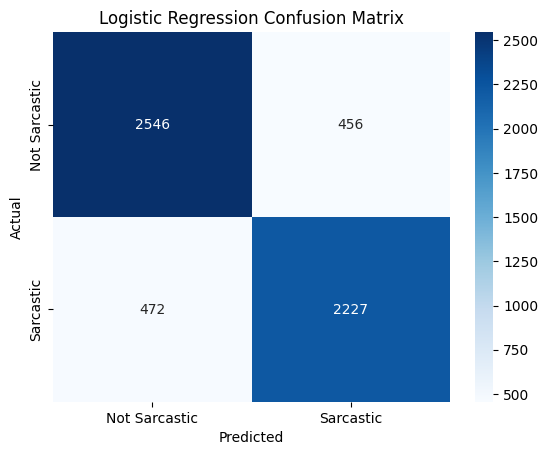

In [ ]:
# Predict on test data
y_pred_lr = lr_model.predict(X_test_tfidf)

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# SVM

SVM Performance:
Accuracy: 0.8285
Precision: 0.8261
Recall: 0.8077
F1-score: 0.8168

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.83      0.85      0.84      3002
    Sarcastic       0.83      0.81      0.82      2699

     accuracy                           0.83      5701
    macro avg       0.83      0.83      0.83      5701
 weighted avg       0.83      0.83      0.83      5701



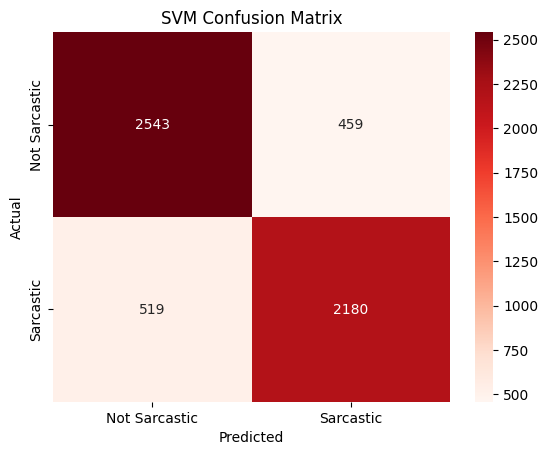

In [ ]:
# Predict on test data
y_pred_svm = svm_model.predict(X_test_tfidf)

# Calculate evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("SVM Performance:")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SVM Confusion Matrix')
plt.show()

# Simple Neural Network (MLP)

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8303 - loss: 0.3696
MLP Test Accuracy: 0.8374
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report for MLP:
               precision    recall  f1-score   support

Not Sarcastic       0.79      0.93      0.86      3002
    Sarcastic       0.91      0.73      0.81      2699

     accuracy                           0.84      5701
    macro avg       0.85      0.83      0.83      5701
 weighted avg       0.85      0.84      0.84      5701



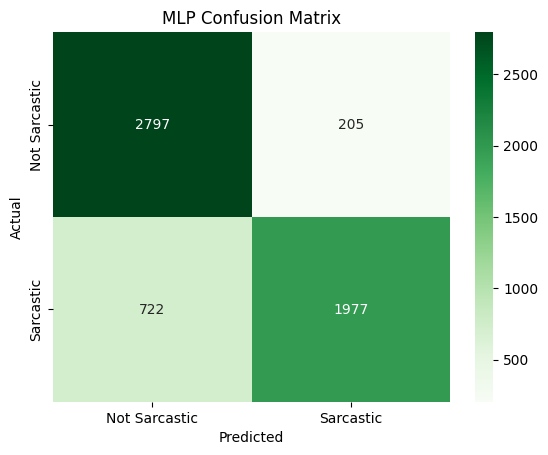

In [ ]:
# Evaluate the MLP model on test data
loss_mlp, accuracy_mlp = mlp_model.evaluate(X_test_padded, y_test)
print(f"MLP Test Accuracy: {accuracy_mlp:.4f}")

# Predict probabilities
y_pred_prob_mlp = mlp_model.predict(X_test_padded)
y_pred_mlp = (y_pred_prob_mlp > 0.5).astype(int)

# Classification Report
print("\nClassification Report for MLP:")
print(classification_report(y_test, y_pred_mlp, target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('MLP Confusion Matrix')
plt.show()

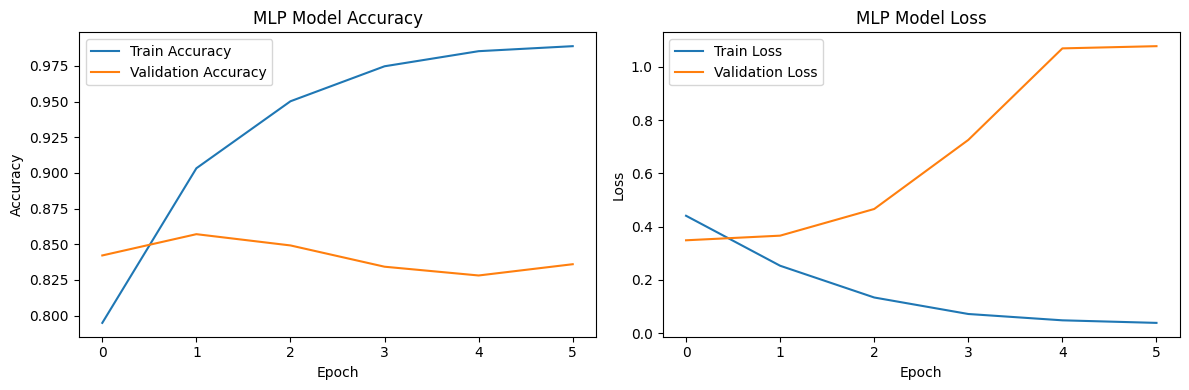

In [ ]:
# Plot accuracy over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# LSTM

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8465 - loss: 0.3581
LSTM Test Accuracy: 0.8525
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report for LSTM:
               precision    recall  f1-score   support

Not Sarcastic       0.85      0.88      0.86      3002
    Sarcastic       0.86      0.82      0.84      2699

     accuracy                           0.85      5701
    macro avg       0.85      0.85      0.85      5701
 weighted avg       0.85      0.85      0.85      5701



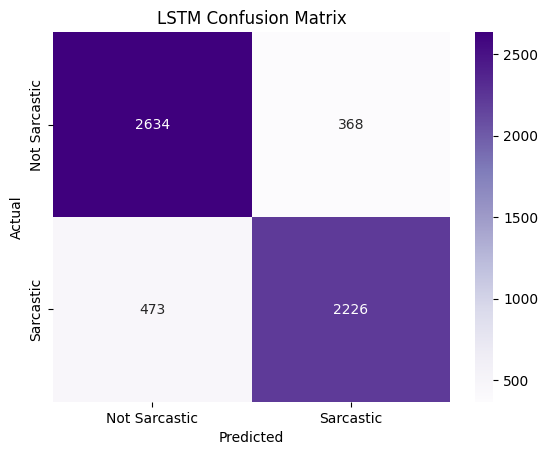

In [ ]:
# Evaluate the LSTM model on test data
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test_padded, y_test)
print(f"LSTM Test Accuracy: {accuracy_lstm:.4f}")

# Predict probabilities
y_pred_prob_lstm = lstm_model.predict(X_test_padded)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

# Classification Report
print("\nClassification Report for LSTM:")
print(classification_report(y_test, y_pred_lstm, target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('LSTM Confusion Matrix')
plt.show()

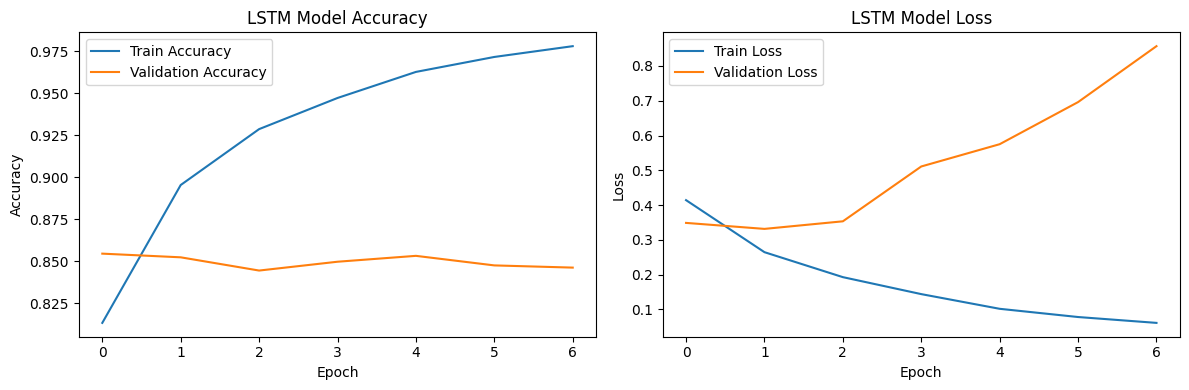

In [ ]:
# Plot accuracy over epochs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# GPT-4o mini

GPT-4o mini Performance:
Accuracy: 0.7300
Precision: 0.6892
Recall: 0.9273
F1-score: 0.7907

Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.85      0.49      0.62        45
    Sarcastic       0.69      0.93      0.79        55

     accuracy                           0.73       100
    macro avg       0.77      0.71      0.71       100
 weighted avg       0.76      0.73      0.71       100



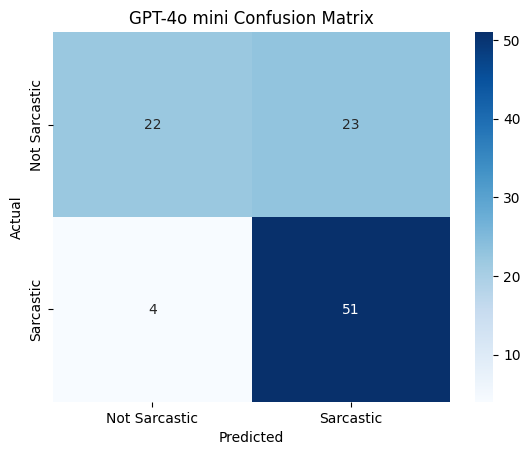

In [ ]:
# Calculate evaluation metrics
accuracy_gpt4o_mini = accuracy_score(y_test_subset, gpt4o_mini_predictions)
precision_gpt4o_mini = precision_score(y_test_subset, gpt4o_mini_predictions)
recall_gpt4o_mini = recall_score(y_test_subset, gpt4o_mini_predictions)
f1_gpt4o_mini = f1_score(y_test_subset, gpt4o_mini_predictions)

print("GPT-4o mini Performance:")
print(f"Accuracy: {accuracy_gpt4o_mini:.4f}")
print(f"Precision: {precision_gpt4o_mini:.4f}")
print(f"Recall: {recall_gpt4o_mini:.4f}")
print(f"F1-score: {f1_gpt4o_mini:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_subset, gpt4o_mini_predictions, target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test_subset, gpt4o_mini_predictions)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('GPT-4o mini Confusion Matrix')
plt.show()

# **Model Comparison**

In [ ]:
# After training and evaluating all models, compare their performance metrics to determine which model performs best on the sarcasm detection task.

# Create a summary table
import pandas as pd

performance_data = {
    'Model': ['Logistic Regression', 'SVM', 'MLP', 'LSTM', 'GPT-4o mini'],
    'Accuracy': [accuracy_lr, accuracy_svm, accuracy_mlp, accuracy_lstm, accuracy_gpt4o_mini],
    'Precision': [precision_lr, precision_svm, precision_score(y_test, y_pred_mlp), precision_score(y_test, y_pred_lstm), precision_gpt4o_mini],
    'Recall': [recall_lr, recall_svm, recall_score(y_test, y_pred_mlp), recall_score(y_test, y_pred_lstm), recall_gpt4o_mini],
    'F1-score': [f1_lr, f1_svm, f1_score(y_test, y_pred_mlp), f1_score(y_test, y_pred_lstm), f1_gpt4o_mini]
}

performance_df = pd.DataFrame(performance_data)
print(performance_df)

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.837222   0.830041  0.825120  0.827573
1                  SVM  0.828451   0.826070  0.807707  0.816785
2                  MLP  0.837397   0.906049  0.732494  0.810080
3                 LSTM  0.852482   0.858134  0.824750  0.841111
4          GPT-4o mini  0.730000   0.689189  0.927273  0.790698


# **Model Interpretability**

# LSTM

In [ ]:
# Use SHAP's Explainer
explainer = shap.Explainer(lstm_model, X_test_padded[:5])

In [ ]:
shap_values = explainer.shap_values(X_test_padded)

PermutationExplainer explainer: 5702it [27:35,  3.42it/s]


In [ ]:
# Assuming you used a tokenizer for preprocessing
word_index = tokenizer.word_index  # Dictionary mapping words to indices
index_word = {v: k for k, v in word_index.items()}  # Reverse mapping: indices to words

In [ ]:
# Convert token indices to words
X_test_words = [[index_word.get(idx, "") for idx in sequence] for sequence in X_test_padded]

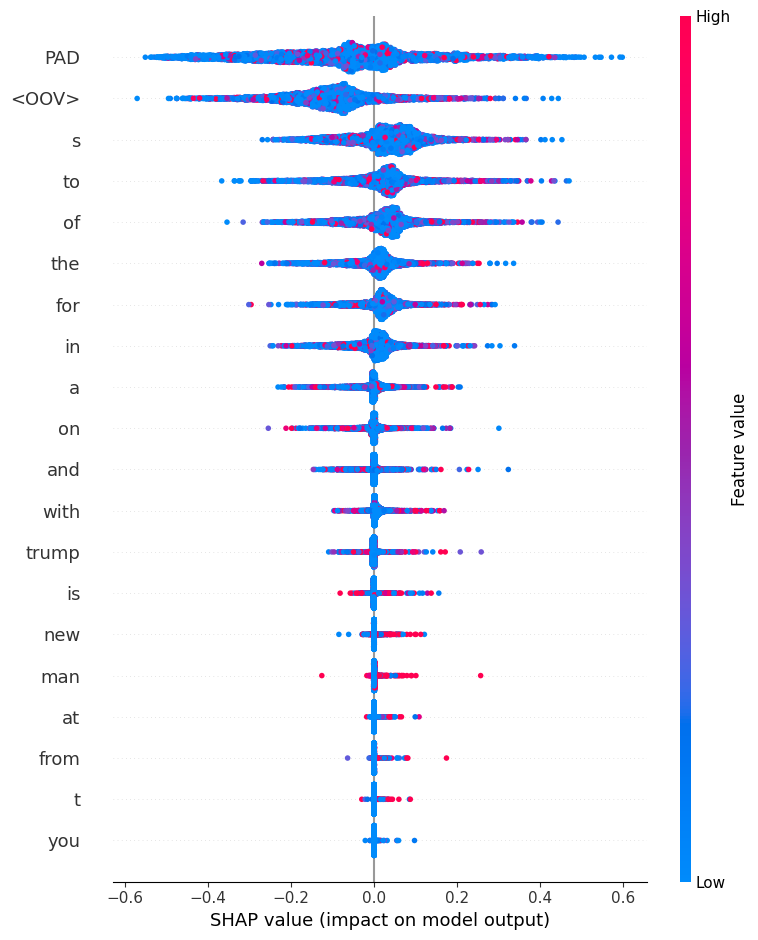

In [ ]:
shap.summary_plot(
    shap_values,  # SHAP values
    X_test_padded,  # Tokenized test data
    feature_names=[index_word.get(idx, "PAD") for idx in range(max_length)]
)

In [ ]:
# # init the JS visualization code
# shap.initjs()

In [ ]:
# words = tokenizer.word_index  # Dictionary mapping words to indices
# num2word = {}
# for w in words.keys():
#     num2word[words[w]] = w
# x_test_words = np.stack([np.array([num2word.get(x, "PAD") for x in x_test[i]]) for i in range(max_length)])

# plot the explanation of the first prediction
# Note the model is "multi-output" because it is rank-2 but only has one column
# shap.force_plot(deep_explainer.expected_value[0], shap_values[0][0], x_test_words[0])